# Create your Vision Chat Assistant with LLaVA

This Colab notebook accompanies the blog post [Create your Vision Chat Assistant with LLaVA](https://medium.com/p/610b02c3283e).

## Install and import dependencies

In [ ]:
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a -q

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO

## Define the chatbot class


In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-7b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        """Load the model, processor and tokenizer."""
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor
        disable_torch_init()

    def setup_image(self, img_path: str) -> None:
        """Load and process the image."""
        if img_path.startswith('http') or img_path.startswith('https'):
            response = requests.get(img_path)
            self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            self.conv_img = Image.open(img_path).convert('RGB')
        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img_path: str,
                       prompt: str,
                       do_sample=True,
                       temperature=0.2,
                       max_new_tokens=1024,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img_path)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles
        first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                       DEFAULT_IM_END_TOKEN + '\n' + prompt)
        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.2,
                      max_new_tokens=1024,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

## Setup the model

Download the model and set up the chatbot. It may take several minutes.

In [ ]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO



def model():
  class LLaVAChatBot:
      def __init__(self,
                  model_path: str = 'liuhaotian/llava-v1.5-7b',
                  device_map: str = 'auto',
                  load_in_8_bit: bool = True,
                  **quant_kwargs) -> None:
          self.model = None
          self.tokenizer = None
          self.image_processor = None
          self.conv = None
          self.conv_img = None
          self.img_tensor = None
          self.roles = None
          self.stop_key = None
          self.load_models(model_path,
                          device_map=device_map,
                          load_in_8_bit=load_in_8_bit,
                          **quant_kwargs)

      def load_models(self, model_path: str,
                      device_map: str,
                      load_in_8_bit: bool,
                      **quant_kwargs) -> None:
          """Load the model, processor and tokenizer."""
          quant_cfg = BitsAndBytesConfig(**quant_kwargs)
          self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                            low_cpu_mem_usage=True,
                                                            device_map=device_map,
                                                            load_in_8bit=load_in_8_bit,
                                                            quantization_config=quant_cfg)
          self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                        use_fast=False)
          vision_tower = self.model.get_vision_tower()
          vision_tower.load_model()
          vision_tower.to(device='cuda')
          self.image_processor = vision_tower.image_processor
          disable_torch_init()

      def setup_image(self, img_path: str) -> None:
          """Load and process the image."""
          if img_path.startswith('http') or img_path.startswith('https'):
              response = requests.get(img_path)
              self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
          else:
              self.conv_img = Image.open(img_path).convert('RGB')
          self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                            return_tensors='pt'
                                                            )['pixel_values'].half().cuda()

      def generate_answer(self, **kwargs) -> str:
          """Generate an answer from the current conversation."""
          raw_prompt = self.conv.get_prompt()
          input_ids = tokenizer_image_token(raw_prompt,
                                            self.tokenizer,
                                            IMAGE_TOKEN_INDEX,
                                            return_tensors='pt').unsqueeze(0).cuda()
          stopping = KeywordsStoppingCriteria([self.stop_key],
                                              self.tokenizer,
                                              input_ids)
          with torch.inference_mode():
              output_ids = self.model.generate(input_ids,
                                              images=self.img_tensor,
                                              stopping_criteria=[stopping],
                                              **kwargs)
          outputs = self.tokenizer.decode(
              output_ids[0, input_ids.shape[1]:]
          ).strip()
          self.conv.messages[-1][-1] = outputs

          return outputs.rsplit('</s>', 1)[0]

      def get_conv_text(self) -> str:
          """Return full conversation text."""
          return self.conv.get_prompt()

      def start_new_chat(self,
                        img_path: str,
                        prompt: str,
                        do_sample=True,
                        temperature=0.2,
                        max_new_tokens=1024,
                        use_cache=True,
                        **kwargs) -> str:
          """Start a new chat with a new image."""
          conv_mode = "v1"
          self.setup_image(img_path)
          self.conv = conv_templates[conv_mode].copy()
          self.roles = self.conv.roles
          first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                        DEFAULT_IM_END_TOKEN + '\n' + prompt)
          self.conv.append_message(self.roles[0], first_input)
          self.conv.append_message(self.roles[1], None)
          if self.conv.sep_style == SeparatorStyle.TWO:
              self.stop_key = self.conv.sep2
          else:
              self.stop_key = self.conv.sep
          answer = self.generate_answer(do_sample=do_sample,
                                        temperature=temperature,
                                        max_new_tokens=max_new_tokens,
                                        use_cache=use_cache,
                                        **kwargs)
          return answer

      def continue_chat(self,
                        prompt: str,
                        do_sample=True,
                        temperature=0.2,
                        max_new_tokens=1024,
                        use_cache=True,
                        **kwargs) -> str:
          """Continue the existing chat."""
          if self.conv is None:
              raise RuntimeError("No existing conversation found. Start a new"
                                "conversation using the `start_new_chat` method.")
          self.conv.append_message(self.roles[0], prompt)
          self.conv.append_message(self.roles[1], None)
          answer = self.generate_answer(do_sample=do_sample,
                                        temperature=temperature,
                                        max_new_tokens=max_new_tokens,
                                        use_cache=use_cache,
                                        **kwargs)
          return answer

  chatbot = LLaVAChatBot(load_in_8bit=True,
                        bnb_8bit_compute_dtype=torch.float16,
                        bnb_8bit_use_double_quant=True,
                        bnb_8bit_quant_type='nf8')

In [ ]:
# !pip install typing_extensions==4.7.1 --upgrade

In [1]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.6 MB

In [4]:
### Gradio app for loading model

import gradio as gr

with gr.Blocks(theme=gr.themes.Glass()) as demo:
  gr.Markdown('# Vision Chat Assistant')
  with gr.Row():
    with gr.Column():
      with gr.Row():
        radio = gr.Radio(['llava-1.5-7b','llava-1.5-13b'],label="Models")
        btn1 = gr.Button(value="Load Model",variant="primary",scale=0.25)
      img = gr.Image()
      with gr.Column():
        with gr.Row():
          txt = gr.Text(lines=2)
          btn = gr.Button(value='Enter',variant="primary",scale=0.25)
    with gr.Column():
      chatbot = gr. Chatbot(scale=6)


  # btn.click(model)

demo.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://5dab3123fb63da3657.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5dab3123fb63da3657.gradio.live


In [ ]:
!pip uninstall typing_extensions --yes

Found existing installation: typing_extensions 4.7.1
Uninstalling typing_extensions-4.7.1:
  Successfully uninstalled typing_extensions-4.7.1


In [ ]:
!pip install typing_extensions

In [ ]:
!pip install gradio

## Chat with the model

Example photo by Arnold Middelkoop on Unsplash.

In [ ]:
ans = chatbot.start_new_chat(img_path="https://stage-drupal.car.co.uk/s3fs-public/styles/original_size/public/2019-09/why-are-number-plates-yellow-and-white.jpg?rt1UJUyIi7L2DpS613hFYlI5ng3U4QT3&itok=3SZjXU0B",
                             prompt="read the car number plate? Think step by step.")

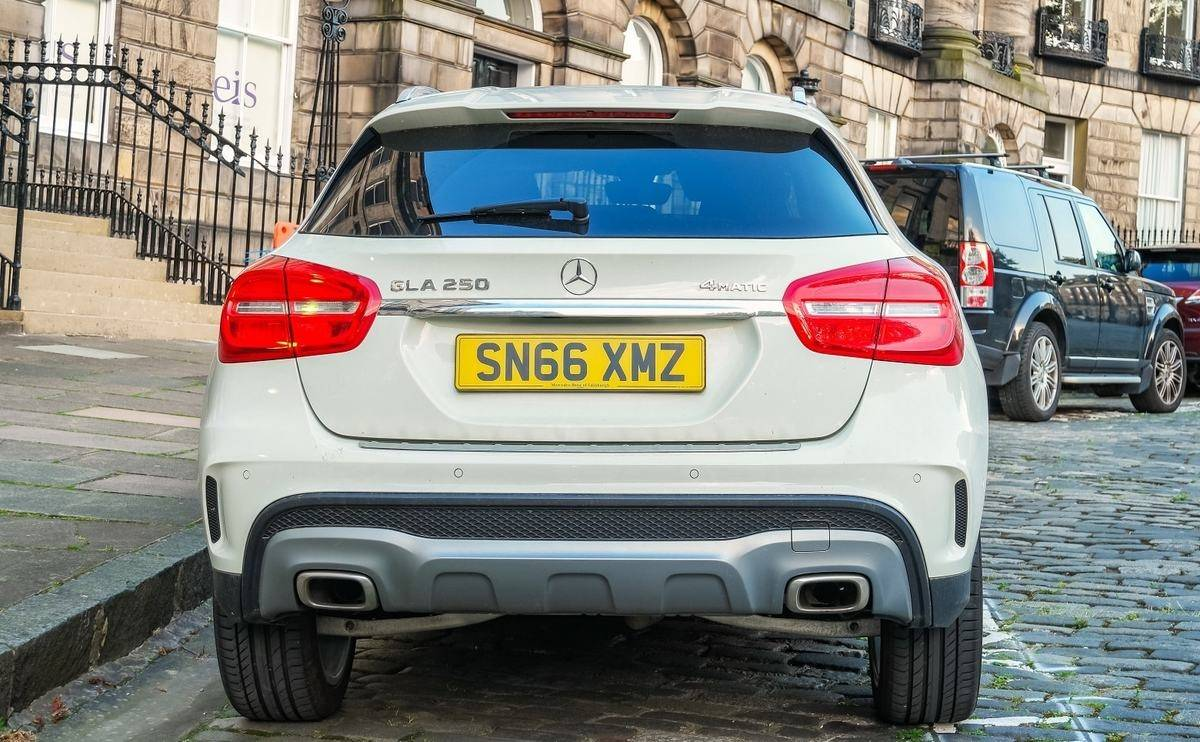

In [ ]:
display(chatbot.conv_img)

In [ ]:
print(ans)

To read the car number plate, follow these steps:

1. Identify the letters and numbers on the plate. In this case, the plate reads "SN66 XMZ."
2. Determine the country code. The country code is "SN," which stands for South Africa.
3. Break down the plate into its components. The first two letters are "SN," followed by the number "66," and the last two letters are "XMZ."
4. Understand the format of the license plate. The license plate consists of a country code, followed by a series of numbers, and then the letters "XMZ."
5. Use the information to identify the car's location and owner. The car is registered in South Africa, and the owner's name starts with the letter "X."


In [ ]:
ans = chatbot.continue_chat("color of car")

In [ ]:
print(ans)

The car is white.


In [ ]:
ans = chatbot.continue_chat("model of car")
print(ans)

The car in the image is a Mercedes-Benz GL-Class SUV.


In [ ]:
ans = chatbot.continue_chat("tell more details about this car")
print(ans)

The Mercedes-Benz GL-Class SUV is a luxury vehicle that offers a spacious interior, advanced technology, and a range of powerful engines. It is part of the Mercedes-Benz GLE-Class lineup, which includes various models such as the GLE 350, GLE 450, GLE 550e, and GLE 63 S.

The GL-Class SUV is known for its comfortable ride, high-quality interior, and impressive safety features. It is available in both rear-wheel drive and all-wheel drive configurations, and it offers a variety of seating options, including a third-row seat for added passenger capacity.

In terms of technology, the GL-Class SUV is equipped with a range of advanced features, such as a touchscreen infotainment system, a 12.3-inch digital instrument cluster, and a 13-speaker Burmester audio system. It also offers various driver assistance systems, including adaptive cruise control, blind-spot monitoring, and lane departure warning.

Under the hood, the GL-Class SUV is powered by a range of engines, including a 2.0-liter tur

In [ ]:
ans = chatbot.continue_chat("tell more details about this car using given image")
print(ans)

The image shows a white Mercedes-Benz GL-Class SUV parked on the street. The car has a large, spacious interior, which is typical of SUVs in the Mercedes-Benz GLE-Class lineup. The exterior of the car is clean and well-maintained, indicating that it is a well-cared-for vehicle.

The car's license plate reads "SN66 XMZ," which is the standard format for UK license plates. The Mercedes-Benz logo can be seen on the front of the car, and the car's overall appearance suggests that it is a high-end luxury vehicle.

The image does not provide enough information to determine the specific model or trim level of the GL-Class SUV, but it is clear that it is a well-maintained, luxurious vehicle that offers a comfortable and spacious interior.


Get the full conversation

In [ ]:
print(chatbot.get_conv_text())

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: <im_start><image><im_end>
Describe Image? Think step by step. ASSISTANT: The image features a large white fish sculpture lying on the ground near a body of water. The fish appears to be a statue or a decorative piece, possibly placed on a sidewalk or a paved area. The water is visible in the background, creating a serene and picturesque scene.

In the vicinity, there are several potted plants, adding a touch of greenery to the environment. Some of these plants are placed close to the water, while others are scattered around the area. The combination of the fish sculpture, the water, and the plants creates a visually appealing and tranquil atmosphere.</s></s>


## Gradio Based Application

In [ ]:
!pip install gradio -q

In [ ]:
import gradio as gr
import random
import time

with gr.Blocks() as demo:
  chatbot = gr.Chatbot()
  msg = gr.Text()
  clear = gr.ClearButton([msg,chatbot])


  def response(message,chat_history):
    bot_message = random.choice(['Hey,Iam your bot how can i help you?','Hello, ask your question'])
    chat_history.append((message,bot_message))
    return "",chat_history

  msg.submit(response,[msg,chatbot],[msg,chatbot])

demo.launch(debug=True)

In [ ]:
import gradio as gr

models = ['llava-1.5','llava']

with gr.Blocks() as demo:
  gr.Markdown("""# LLM Based Vision Assistant""")
  with gr.Row():
    with gr.Column():
      with gr.Row():
        model_selector = gr.Radio(choices=models,label="Models",interactive=True)

      imagebox = gr.Image(type='pil')



    with gr.Column():
        chatbot = gr.Chatbot(elem_id='chatbot',label='CHATBOT',layout='panel')
        with gr.Row():
          with gr.Column(scale=8):
            textbox = gr.Textbox(show_label=False, placeholder="Enter text and press ENTER")  #gr.Textbox(show_label=False, placeholder="Enter text and press ENTER", container=False).render()
          with gr.Column(scale=1, min_width=50):
            submit_btn = gr.Button(value="Send", variant="primary")

submit_btn.click(add_text,[state,textbox,image_process_mode],[state,chatbot,textbox,imagebox] + btn_list).then(http_bot,[state,model_selector,temperature,top_p,max_output_tokens],[state,chatbot],btn_list),)


demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://26afe50da2fb03358f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://26afe50da2fb03358f.gradio.live


# HuggingFace based Gradio Application

In [ ]:
!git lfs install
!git clone https://huggingface.co/spaces/ysharma/LLaVA_v1

Git LFS initialized.
fatal: destination path 'LLaVA_v1' already exists and is not an empty directory.


In [ ]:
%cd /content/LLaVA_v1

/content/LLaVA_v1


In [ ]:
!pwd

/content/LLaVA_v1


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install gradio

In [ ]:
import argparse
import datetime
import hashlib
import json
import os
import subprocess
import sys
import time

import gradio as gr
import requests

from llava.constants import LOGDIR
from llava.conversation import SeparatorStyle, conv_templates, default_conversation
from llava.utils import (
    build_logger,
    moderation_msg,
    server_error_msg,
    violates_moderation,
)

logger = build_logger("gradio_web_server", "gradio_web_server.log")

headers = {"User-Agent": "LLaVA Client"}

no_change_btn = gr.Button.update()
enable_btn = gr.Button.update(interactive=True)
disable_btn = gr.Button.update(interactive=False)

priority = {
    "vicuna-13b": "aaaaaaa",
    "koala-13b": "aaaaaab",
}


def get_conv_log_filename():
    t = datetime.datetime.now()
    name = os.path.join('logs', f"{t.year}-{t.month:02d}-{t.day:02d}-conv.json")
    return name


def get_model_list():
    ret = requests.post(args.controller_url + "/refresh_all_workers")
    assert ret.status_code == 200
    ret = requests.post(args.controller_url + "/list_models")
    models = ret.json()["models"]
    models.sort(key=lambda x: priority.get(x, x))
    logger.info(f"Models: {models}")
    return models


get_window_url_params = """
function() {
    const params = new URLSearchParams(window.location.search);
    url_params = Object.fromEntries(params);
    console.log(url_params);
    return url_params;
    }
"""


def load_demo(url_params, request: gr.Request):
    logger.info(f"load_demo. ip: {request.client.host}. params: {url_params}")

    dropdown_update = gr.Dropdown.update(visible=True)
    if "model" in url_params:
        model = url_params["model"]
        if model in models:
            dropdown_update = gr.Dropdown.update(value=model, visible=True)

    state = default_conversation.copy()
    return state, dropdown_update


def load_demo_refresh_model_list(request: gr.Request):
    logger.info(f"load_demo. ip: {request.client.host}")
    models = get_model_list()
    state = default_conversation.copy()
    dropdown_update = gr.Dropdown.update(
        choices=models, value=models[0] if len(models) > 0 else ""
    )
    return state, dropdown_update


def vote_dummy_fn(tmp, index_state):  #, data: gr.LikeData):
    value_new = data.value
    index_new = data.index
    if len(index_state) == 0 :
        index_state.append(index_new)
    else:
        if index_new in index_state:
            gr.Warning('Your feedback is already saved.')
            return index_state
        else:
            index_state.append(index_new)

    #return str(data.value) + ";" + str(data.index)+";"+ str(data.liked)+";"+str(index_state), index_state
    return index_state

#chatbot.like(vote_last_response, [model_selector, index_state], [index_state])
def vote_last_response(chatbot, model_selector, index_state, request: gr.Request):  ##, data: gr.LikeData):

    vote_type = "upvote" if data.liked else "downvote"
    vote_value = data.value
    vote_index = data.index
    if len(index_state) == 0 :
        index_state.append(vote_index)
    else:
        if vote_index in index_state:
            gr.Warning('Your feedback is already saved.')
            return index_state
        else:
            index_state.append(vote_index)

    with open(get_conv_log_filename(), "a") as fout:
        data = {
            "tstamp": round(time.time(), 4),
            "type": vote_type,
            "model": model_selector,
            "state": chatbot[vote_index[0]],
            "ip": request.client.host,
        }
        logger.info(f"^^^^^ data is - {data}")
        fout.write(json.dumps(data) + "\n")

    return index_state

def vote_last_response_old(state, vote_type, model_selector, request: gr.Request):
    with open(get_conv_log_filename(), "a") as fout:
        data = {
            "tstamp": round(time.time(), 4),
            "type": vote_type,
            "model": model_selector,
            "state": state.dict(),
            "ip": request.client.host,
        }
        #print(f"^^^^^ data is - {data}")
        logger.info(f"^^^^^ data is - {data}")
        fout.write(json.dumps(data) + "\n")


def upvote_last_response(state, model_selector, request: gr.Request):
    print()
    logger.info(f"upvote. ip: {request.client.host}")
    vote_last_response(state, "upvote", model_selector, request)
    return ("",) + (disable_btn,) * 3


def downvote_last_response(state, model_selector, request: gr.Request):
    logger.info(f"downvote. ip: {request.client.host}")
    vote_last_response(state, "downvote", model_selector, request)
    return ("",) + (disable_btn,) * 3


def flag_last_response(state, model_selector, request: gr.Request):
    logger.info(f"flag. ip: {request.client.host}")
    vote_last_response(state, "flag", model_selector, request)
    return ("",) + (disable_btn,) * 3


def regenerate(state, image_process_mode, request: gr.Request):
    logger.info(f"regenerate. ip: {request.client.host}")
    state.messages[-1][-1] = None
    prev_human_msg = state.messages[-2]
    if type(prev_human_msg[1]) in (tuple, list):
        prev_human_msg[1] = (*prev_human_msg[1][:2], image_process_mode)
    state.skip_next = False
    return (state, state.to_gradio_chatbot(), "", None) + (disable_btn,) * 5


def clear_history(request: gr.Request):
    logger.info(f"clear_history. ip: {request.client.host}")
    state = default_conversation.copy()
    return (state, state.to_gradio_chatbot(), "", None) + (disable_btn,) * 5


def add_text(state, text, image, image_process_mode, request: gr.Request):
    logger.info(f"add_text. ip: {request.client.host}. len: {len(text)}")
    if len(text) <= 0 and image is None:
        state.skip_next = True
        return (state, state.to_gradio_chatbot(), "", None) + (no_change_btn,) * 5
    if args.moderate:
        flagged = violates_moderation(text)
        if flagged:
            state.skip_next = True
            return (state, state.to_gradio_chatbot(), moderation_msg, None) + (
                no_change_btn,
            ) * 5

    text = text[:1536]  # Hard cut-off
    if image is not None:
        text = text[:1200]  # Hard cut-off for images
        if "<image>" not in text:
            # text = '<Image><image></Image>' + text
            text = text + "\n<image>"
        text = (text, image, image_process_mode)
        if len(state.get_images(return_pil=True)) > 0:
            state = default_conversation.copy()
    state.append_message(state.roles[0], text)
    state.append_message(state.roles[1], None)
    state.skip_next = False
    return (state, state.to_gradio_chatbot(), "", None) + (disable_btn,) * 5


def http_bot(
    state, model_selector, temperature, top_p, max_new_tokens, request: gr.Request
):
    logger.info(f"http_bot. ip: {request.client.host}")
    start_tstamp = time.time()
    model_name = model_selector

    if state.skip_next:
        # This generate call is skipped due to invalid inputs
        yield (state, state.to_gradio_chatbot()) + (no_change_btn,) * 5
        return

    if len(state.messages) == state.offset + 2:
        # First round of conversation
        if "llava" in model_name.lower():
            if "llama-2" in model_name.lower():
                template_name = "llava_llama_2"
            elif "v1" in model_name.lower():
                if "mmtag" in model_name.lower():
                    template_name = "v1_mmtag"
                elif (
                    "plain" in model_name.lower()
                    and "finetune" not in model_name.lower()
                ):
                    template_name = "v1_mmtag"
                else:
                    template_name = "llava_v1"
            elif "mpt" in model_name.lower():
                template_name = "mpt"
            else:
                if "mmtag" in model_name.lower():
                    template_name = "v0_mmtag"
                elif (
                    "plain" in model_name.lower()
                    and "finetune" not in model_name.lower()
                ):
                    template_name = "v0_mmtag"
                else:
                    template_name = "llava_v0"
        elif "mpt" in model_name:
            template_name = "mpt_text"
        elif "llama-2" in model_name:
            template_name = "llama_2"
        else:
            template_name = "vicuna_v1"
        new_state = conv_templates[template_name].copy()
        new_state.append_message(new_state.roles[0], state.messages[-2][1])
        new_state.append_message(new_state.roles[1], None)
        state = new_state

    # Query worker address
    controller_url = args.controller_url
    ret = requests.post(
        controller_url + "/get_worker_address", json={"model": model_name}
    )
    worker_addr = ret.json()["address"]
    logger.info(f"model_name: {model_name}, worker_addr: {worker_addr}")

    # No available worker
    if worker_addr == "":
        state.messages[-1][-1] = server_error_msg
        yield (
            state,
            state.to_gradio_chatbot(),
            disable_btn,
            disable_btn,
            disable_btn,
            enable_btn,
            enable_btn,
        )
        return

    # Construct prompt
    prompt = state.get_prompt()

    all_images = state.get_images(return_pil=True)
    all_image_hash = [hashlib.md5(image.tobytes()).hexdigest() for image in all_images]
    for image, hash in zip(all_images, all_image_hash):
        t = datetime.datetime.now()
        filename = os.path.join(
            LOGDIR, "serve_images", f"{t.year}-{t.month:02d}-{t.day:02d}", f"{hash}.jpg"
        )
        if not os.path.isfile(filename):
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            image.save(filename)

    # Make requests
    pload = {
        "model": model_name,
        "prompt": prompt,
        "temperature": float(temperature),
        "top_p": float(top_p),
        "max_new_tokens": min(int(max_new_tokens), 1536),
        "stop": state.sep
        if state.sep_style in [SeparatorStyle.SINGLE, SeparatorStyle.MPT]
        else state.sep2,
        "images": f"List of {len(state.get_images())} images: {all_image_hash}",
    }
    logger.info(f"==== request ====\n{pload}")

    pload["images"] = state.get_images()

    state.messages[-1][-1] = "▌"
    yield (state, state.to_gradio_chatbot()) + (disable_btn,) * 5

    try:
        # Stream output
        response = requests.post(
            worker_addr + "/worker_generate_stream",
            headers=headers,
            json=pload,
            stream=True,
            timeout=10,
        )
        for chunk in response.iter_lines(decode_unicode=False, delimiter=b"\0"):
            if chunk:
                data = json.loads(chunk.decode())
                if data["error_code"] == 0:
                    output = data["text"][len(prompt) :].strip()
                    state.messages[-1][-1] = output + "▌"
                    yield (state, state.to_gradio_chatbot()) + (disable_btn,) * 5
                else:
                    output = data["text"] + f" (error_code: {data['error_code']})"
                    state.messages[-1][-1] = output
                    yield (state, state.to_gradio_chatbot()) + (
                        disable_btn,
                        disable_btn,
                        disable_btn,
                        enable_btn,
                        enable_btn,
                    )
                    return
                time.sleep(0.03)
    except requests.exceptions.RequestException as e:
        state.messages[-1][-1] = server_error_msg
        yield (state, state.to_gradio_chatbot()) + (
            disable_btn,
            disable_btn,
            disable_btn,
            enable_btn,
            enable_btn,
        )
        return

    state.messages[-1][-1] = state.messages[-1][-1][:-1]
    yield (state, state.to_gradio_chatbot()) + (enable_btn,) * 5

    finish_tstamp = time.time()
    logger.info(f"{output}")

    with open(get_conv_log_filename(), "a") as fout:
        data = {
            "tstamp": round(finish_tstamp, 4),
            "type": "chat",
            "model": model_name,
            "start": round(start_tstamp, 4),
            "finish": round(start_tstamp, 4),
            "state": state.dict(),
            "images": all_image_hash,
            "ip": request.client.host,
        }
        fout.write(json.dumps(data) + "\n")


title_markdown = """
# 🌋 LLaVA: Large Language and Vision Assistant
[[Project Page]](https://llava-vl.github.io) [[Paper]](https://arxiv.org/abs/2304.08485) [[Code]](https://github.com/haotian-liu/LLaVA) [[Model]](https://github.com/haotian-liu/LLaVA/blob/main/docs/MODEL_ZOO.md)
ONLY WORKS WITH GPU!
You can load the model with 8-bit or 4-bit quantization to make it fit in smaller hardwares. Setting the environment variable `bits` to control the quantization.
Recommended configurations:
| Hardware          | A10G-Large (24G) | T4-Medium (15G) | A100-Large (40G) |
|-------------------|------------------|-----------------|------------------|
| **Bits**          | 8 (default)      | 4               | 16               |
"""

tos_markdown = """
### Terms of use
By using this service, users are required to agree to the following terms:
The service is a research preview intended for non-commercial use only. It only provides limited safety measures and may generate offensive content. It must not be used for any illegal, harmful, violent, racist, or sexual purposes. The service may collect user dialogue data for future research.
Please click the "Flag" button if you get any inappropriate answer! We will collect those to keep improving our moderator.
For an optimal experience, please use desktop computers for this demo, as mobile devices may compromise its quality.
"""


learn_more_markdown = """
### License
The service is a research preview intended for non-commercial use only, subject to the model [License](https://github.com/facebookresearch/llama/blob/main/MODEL_CARD.md) of LLaMA, [Terms of Use](https://openai.com/policies/terms-of-use) of the data generated by OpenAI, and [Privacy Practices](https://chrome.google.com/webstore/detail/sharegpt-share-your-chatg/daiacboceoaocpibfodeljbdfacokfjb) of ShareGPT. Please contact us if you find any potential violation.
"""

block_css = """
#buttons button {
    min-width: min(120px,100%);
}
"""


def build_demo(embed_mode):
    models = get_model_list()

    textbox = gr.Textbox(
        show_label=False, placeholder="Enter text and press ENTER", container=False
    )
    with gr.Blocks(title="LLaVA", theme=gr.themes.Default(), css=block_css) as demo:
        state = gr.State(default_conversation.copy())

        if not embed_mode:
            gr.Markdown(title_markdown)

        with gr.Row():
            with gr.Column(scale=3):
                with gr.Row(elem_id="model_selector_row"):
                    model_selector = gr.Dropdown(
                        choices=models,
                        value=models[0] if len(models) > 0 else "",
                        interactive=True,
                        show_label=False,
                        container=False,
                    )

                imagebox = gr.Image(type="pil")
                image_process_mode = gr.Radio(
                    ["Crop", "Resize", "Pad", "Default"],
                    value="Default",
                    label="Preprocess for non-square image",
                    visible=False,
                )

                cur_dir = os.path.dirname(os.path.abspath(__file__))
                gr.Examples(
                    examples=[
                        [
                            f"{cur_dir}/examples/extreme_ironing.jpg",
                            "What is unusual about this image?",
                        ],
                        [
                            f"{cur_dir}/examples/waterview.jpg",
                            "What are the things I should be cautious about when I visit here?",
                        ],
                    ],
                    inputs=[imagebox, textbox],
                )

                with gr.Accordion("Parameters", open=False) as parameter_row:
                    temperature = gr.Slider(
                        minimum=0.0,
                        maximum=1.0,
                        value=0.2,
                        step=0.1,
                        interactive=True,
                        label="Temperature",
                    )
                    top_p = gr.Slider(
                        minimum=0.0,
                        maximum=1.0,
                        value=0.7,
                        step=0.1,
                        interactive=True,
                        label="Top P",
                    )
                    max_output_tokens = gr.Slider(
                        minimum=0,
                        maximum=1024,
                        value=512,
                        step=64,
                        interactive=True,
                        label="Max output tokens",
                    )

            with gr.Column(scale=8):
                chatbot = gr.Chatbot(
                    elem_id="chatbot",
                    label="LLaVA Chatbot",
                    height=550,
                    avatar_images = (None, "llava_logo.png"),
                    layout = "panel",
                )
                index_state = gr.State(value=[])
                with gr.Row():
                    with gr.Column(scale=8):
                        textbox.render()
                    with gr.Column(scale=1, min_width=50):
                        submit_btn = gr.Button(value="Send", variant="primary")
                with gr.Row(elem_id="buttons") as button_row:
                    upvote_btn = gr.Button(value="👍  Upvote", interactive=False)
                    downvote_btn = gr.Button(value="👎  Downvote", interactive=False)
                    flag_btn = gr.Button(value="⚠️  Flag", interactive=False)
                    # stop_btn = gr.Button(value="⏹️  Stop Generation", interactive=False)
                    regenerate_btn = gr.Button(value="🔄  Regenerate", interactive=False)
                    clear_btn = gr.Button(value="🗑️  Clear history", interactive=False)

        if not embed_mode:
            gr.Markdown(tos_markdown)
            gr.Markdown(learn_more_markdown)
        url_params = gr.JSON(visible=False)

        # Register listeners
        btn_list = [upvote_btn, downvote_btn, flag_btn, regenerate_btn, clear_btn]
        upvote_btn.click(
            upvote_last_response,
            [state, model_selector],
            [textbox, upvote_btn, downvote_btn, flag_btn],
        )
        downvote_btn.click(
            downvote_last_response,
            [state, model_selector],
            [textbox, upvote_btn, downvote_btn, flag_btn],
        )
        flag_btn.click(
            flag_last_response,
            [state, model_selector],
            [textbox, upvote_btn, downvote_btn, flag_btn],
        )
        regenerate_btn.click(
            regenerate,
            [state, image_process_mode],
            [state, chatbot, textbox, imagebox] + btn_list,
        ).then(
            http_bot,
            [state, model_selector, temperature, top_p, max_output_tokens],
            [state, chatbot] + btn_list,
        )
        clear_btn.click(
            clear_history, None, [state, chatbot, textbox, imagebox] + btn_list
        )

        textbox.submit(
            add_text,
            [state, textbox, imagebox, image_process_mode],
            [state, chatbot, textbox, imagebox] + btn_list,
        ).then(
            http_bot,
            [state, model_selector, temperature, top_p, max_output_tokens],
            [state, chatbot] + btn_list,
        )
        submit_btn.click(
            add_text,
            [state, textbox, imagebox, image_process_mode],
            [state, chatbot, textbox, imagebox] + btn_list,
        ).then(
            http_bot,
            [state, model_selector, temperature, top_p, max_output_tokens],
            [state, chatbot] + btn_list,
        )

        # For adding voting option to chatbot
        chatbot.like(vote_last_response, [chatbot, model_selector, index_state], [index_state])
        #def vote_last_response(chatbot, model_selector, index_state, request: gr.Request, data: gr.LikeData):
        #state, model_selector, request: gr.Request

        if args.model_list_mode == "once":
            demo.load(
                load_demo,
                [url_params],
                [state, model_selector],
                _js=get_window_url_params,
            )
        elif args.model_list_mode == "reload":
            demo.load(load_demo_refresh_model_list, None, [state, model_selector])
        else:
            raise ValueError(f"Unknown model list mode: {args.model_list_mode}")

    return demo


def start_controller():
    logger.info("Starting the controller")
    controller_command = [
        "python",
        "-m",
        "llava.serve.controller",
        "--host",
        "0.0.0.0",
        "--port",
        "10000",
    ]
    return subprocess.Popen(controller_command)


def start_worker(model_path: str, bits=16):
    logger.info(f"Starting the model worker for the model {model_path}")
    model_name = model_path.strip('/').split('/')[-1]
    assert bits in [4, 8, 16], "It can be only loaded with 16-bit, 8-bit, and 4-bit."
    if bits != 16:
        model_name += f'-{bits}bit'
    worker_command = [
        "python",
        "-m",
        "llava.serve.model_worker",
        "--host",
        "0.0.0.0",
        "--controller",
        "http://localhost:10000",
        "--model-path",
        model_path,
        "--model-name",
        model_name,
    ]
    if bits != 16:
        worker_command += [f'--load-{bits}bit']
    return subprocess.Popen(worker_command)


def preload_models(model_path: str):
    import torch

    from llava.model import LlavaLlamaForCausalLM

    model = LlavaLlamaForCausalLM.from_pretrained(
        model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16
    )
    vision_tower = model.get_vision_tower()
    vision_tower.load_model()

    del vision_tower
    del model


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--host", type=str, default="0.0.0.0")
    parser.add_argument("--port", type=int)
    parser.add_argument("--controller-url", type=str, default="http://localhost:10000")
    parser.add_argument("--concurrency-count", type=int, default=8)
    parser.add_argument(
        "--model-list-mode", type=str, default="reload", choices=["once", "reload"]
    )
    parser.add_argument("--share", action="store_true")
    parser.add_argument("--moderate", action="store_true")
    parser.add_argument("--embed", action="store_true")

    args = parser.parse_args()

    return args


def start_demo(args):
    demo = build_demo(args.embed)
    demo.queue(
        concurrency_count=args.concurrency_count, status_update_rate=10, api_open=False
    ).launch(server_name=args.host, server_port=args.port, share=args.share)


if __name__ == "__main__":
    args = get_args()
    logger.info(f"args: {args}")

    model_path = "liuhaotian/llava-v1.5-7b"
    bits = int(os.getenv("bits", 8))

    preload_models(model_path)

    controller_proc = start_controller()
    worker_proc = start_worker(model_path, bits=bits)

    # Wait for worker and controller to start
    time.sleep(10)

    try:
        start_demo(args)
    except Exception as e:
        worker_proc.terminate()
        controller_proc.terminate()

        print(e)
        sys.exit(1)



SystemExit: ignored

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.0 MB/

In [ ]:
import gradio as gr
import random
import time

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        bot_message = random.choice(["How are you?", "I love you", "I'm very hungry"])
        time.sleep(2)
        history[-1][1] = bot_message
        return history

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, chatbot
    )
    clear.click(lambda: None, None, chatbot, queue=False)

demo.queue()
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3964f9d49b97eb3a61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import os
import time

# Chatbot demo with multimodal input (text, markdown, LaTeX, code blocks, image, audio, & video). Plus shows support for streaming text.


def add_text(history, text):
    history = history + [(text, None)]
    return history, gr.Textbox(value="", interactive=False)


def add_file(history, file):
    history = history + [((file.name,), None)]
    return history


def bot(history):
    response = "**That's cool!**"
    history[-1][1] = ""
    for character in response:
        history[-1][1] += character
        time.sleep(0.05)
        yield history


with gr.Blocks() as demo:
    chatbot = gr.Chatbot(
        [],
        elem_id="chatbot",
        bubble_full_width=False,)

    with gr.Row():
        txt = gr.Textbox(
            scale=4,
            show_label=False,
            placeholder="Enter text and press enter, or upload an image",
            container=False,
        )
        btn = gr.UploadButton("📁", file_types=["image", "video", "audio"])

    txt_msg = txt.submit(add_text, [chatbot, txt], [chatbot, txt], queue=False).then(
        bot, chatbot, chatbot, api_name="bot_response"
    )
    txt_msg.then(lambda: gr.Textbox(interactive=True), None, [txt], queue=False)
    file_msg = btn.upload(add_file, [chatbot, btn], [chatbot], queue=False).then(
        bot, chatbot, chatbot
    )

demo.queue()
if __name__ == "__main__":
    demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e657caff50399fb450.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Chainlit Application

In [ ]:
!pip install chainlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 7.2 MB/s eta 0:00:0

In [ ]:
import chainlit as cl


# continously on loop
@cl.on_message
def main(message:str):
  # your logic
  result = message.title()


  # send a response back to user
  cl.send_message(content=f" sure here is a message:{result}")



## Panel Based Application UI

In [ ]:
text = pn.widgets.TextInput()

def b(event):
  text_value = "clicked {0} times".format(button.clicks)

button.on_click(b)
pn.Row(text,button)

Row
    [0] TextInput()
    [1] Button(button_type='primary', name='Enter')

In [ ]:
import numpy as np
import panel as pn
import matplotlib.pyplot as plt

pn.extension(template='fast')

freq = pn.widgets.FloatSlider(name="frequency",start=0,end=10,value=5).servable(target="sidebar")
ampl = pn.widgets.FloatSlider(name="Amplitude",start=0,end=1,value=0.5).servable(target="sidebar")

def plot(freq,ampl):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.linspace(0,1)
    ys = np.sin(xs*freq)*ampl
    ax.plot(xs,ys)
    return fig

mpl = pn.pane.Matplotlib(pn.bind(plot,freq,ampl))

pn.Column('# Sine Curve',mpl).servable(target='main')

In [ ]:
import numpy as np
import panel as pn
import matplotlib.pyplot as plt

pn.extension(template='fast')

In [ ]:
freq = pn.widgets.FloatSlider(name="frequency",start=0,end=10,value=5).servable(target="sidebar")
freq

FloatSlider(end=10, name='frequency', value=5)

In [ ]:
inp = pn.widgets.TextInput()
b1 = pn.widgets.Button(name='Enter',button_type='primary')

pn.Row(inp,b1)

# convo = pn.bind(inp,b1)
# convo

Row
    [0] TextInput()
    [1] Button(button_type='primary', name='Enter')

In [ ]:
import panel as pn
from panel.chat import ChatInterface

pn.extension("perspective")

In [ ]:
ChatInterface()

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'TextInput': TextInput(cs...}, show_button_name=True, sizing_mode='stretch_width', widgets=[TextInput(css_classes=['c...])

In [ ]:
def even_or_odd(contents, user, instance):
    if len(contents) % 2 == 0:
        return "Even number of characters."
    return "Odd number of characters."

ChatInterface(callback=even_or_odd)

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'TextInput': TextInput(cs...}, callback=<function even_or_odd a..., show_button_name=True, sizing_mode='stretch_width', widgets=[TextInput(css_classes=['c...])

In [ ]:
ChatInterface(
    callback=even_or_odd,
    user="Asker",
    avatar="?",
    callback_user="Counter",
)

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'TextInput': TextInput(cs...}, avatar='?', callback=<function even_or_odd a..., callback_user='Counter', show_button_name=True, sizing_mode='stretch_width', user='Asker', widgets=[TextInput(css_classes=['c...])